# 第5章 ベイズ推論プログラミング

## モジュールのimport

In [ ]:
# Module
import sys
sys.path.append("../")
from mod.numpyro_utility import *

# DataFrame, Numerical computation
import polars as pl
pl.Config(fmt_str_lengths = 100, tbl_cols = 100, tbl_rows = 100)
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

# ベイズ推定
import numpyro
import numpyro.distributions as dist # 確率分布

# plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

# plotの設定
import json
def to_rc_dict(dict):
    """
    jsonファイルのdictを読み込む
    """
    return {f'{k1}.{k2}': v for k1,d in dict.items() for k2,v in d.items()}

file_path = "../mod/rcParams.json"
with open(file_path) as f: 
    plt.rcParams.update(to_rc_dict(json.load(f)))

# 日本語 or 英語の2択
import japanize_matplotlib
#plt.rcParams['font.family'] = "Times New Roman"

## 5.1 データ分布のベイズ推論
### 5.1.1 問題設定
```setosa```の```sepal_length```のデータ分布が正規分布に従うと仮定して、```sepal_length```の分布の形を調べる。

### 5.1.2 データ準備
```seaborn```の```iris```データセットを読み込む。\
```setosa```の萼片（がくへん）の長さ```sepal_length```を抽出する。\
```sepal_length```の分布に興味があるため目的変数の $y$ とする。

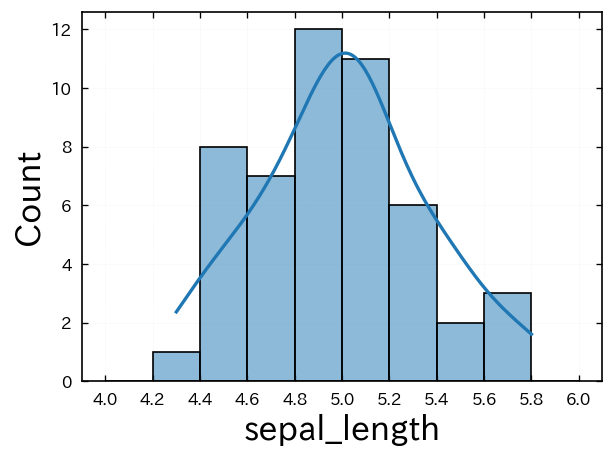

In [4]:
# データセットを読み込む
df = sns.load_dataset("iris")

# setosa を抽出する
df_setosa = df.query('species == "setosa"')

# ヒストグラムを描画
bins = np.arange(4.0, 6.2, 0.2)
sns.histplot(data = df_setosa, x = "sepal_length", bins = bins, kde = True)
plt.xticks(bins);

In [5]:
# NumPy変数の1次元配列に変換
Y = jnp.array(df_setosa['sepal_length'].values, dtype = float)

# 統計情報の確認
print(df_setosa['sepal_length'].describe())

# 値の確認
print(Y)

count    50.00000
mean      5.00600
std       0.35249
min       4.30000
25%       4.80000
50%       5.00000
75%       5.20000
max       5.80000
Name: sepal_length, dtype: float64
[5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
 5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
 5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5. ]


### 5.1.3 確率モデル定義

前章と同様に数式で整理してから確率モデルをプログラミングする。

1. ```setosa```の```sepal_length```のデータ分布が正規分布に従うと仮定する
    * $y_{i} \sim N(\mu, \sigma^2)$
1. 正規分布のパラメータに関する情報は無い。
    1. 正規分布の平均 $\mu$ が取りうる値はかなり広いものとする。
        * ヒストグラムより平均0, 標準偏差10の正規分布に従うと仮定する。
    1. 正規分布の標準偏差 $\sigma$ が取りうる値はかなり広いものとする。
        * 標準偏差10の半正規分布に従うと仮定する。

確率モデルは数式のまとめを終わりから実装していく。

In [6]:
def model_normal(N, Y = None):
    '''
        5.1節のSetosaのがく片長さの確率分布モデル
    '''
    # 2.2. 正規分布の標準偏差 $\sigma$は標準偏差10の半正規分布に従うと仮定する。
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale = 10))
    # 2.1. 正規分布の平均 $\mu$ はヒストグラムより平均0, 標準偏差10の正規分布に従うと仮定する。
    mu = numpyro.sample("mu", dist.Normal(loc = 0, scale = 10))
    # ベクトル化
    with numpyro.plate("N", N):
        # 1. $y_{i} \sim N(\mu, \sigma^2)$
        numpyro.sample("Y", dist.Normal(loc = mu, scale = sigma), obs = Y)

Model graph saved to: Setosa's sepal length.svg


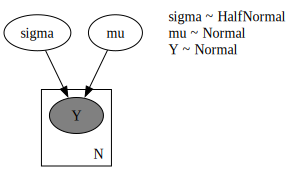

"Setosa's sepal length.svg"

In [7]:
model_args = {
    "N": len(Y),
    "Y": Y
}
try_render_model(model_normal, render_name = "Setosa's sepal length", **model_args)

### 5.1.4 サンプリング

In [8]:
model_args = {
    "N": len(Y),
    "Y": Y
}
idata = run_mcmc(
    model_normal,
    num_chains = 4,
    num_warmup = 1000,
    num_samples = 1000,
    thinning = 1,
    seed = 42,
    target_accept_prob = 0.8,
    log_likelihood = False,
    **model_args
)

sample: 100%|██████████| 2000/2000 [00:00<00:00, 5194.85it/s, 7 steps of size 7.10e-01. acc. prob=0.95]


### 5.1.5 結果分析

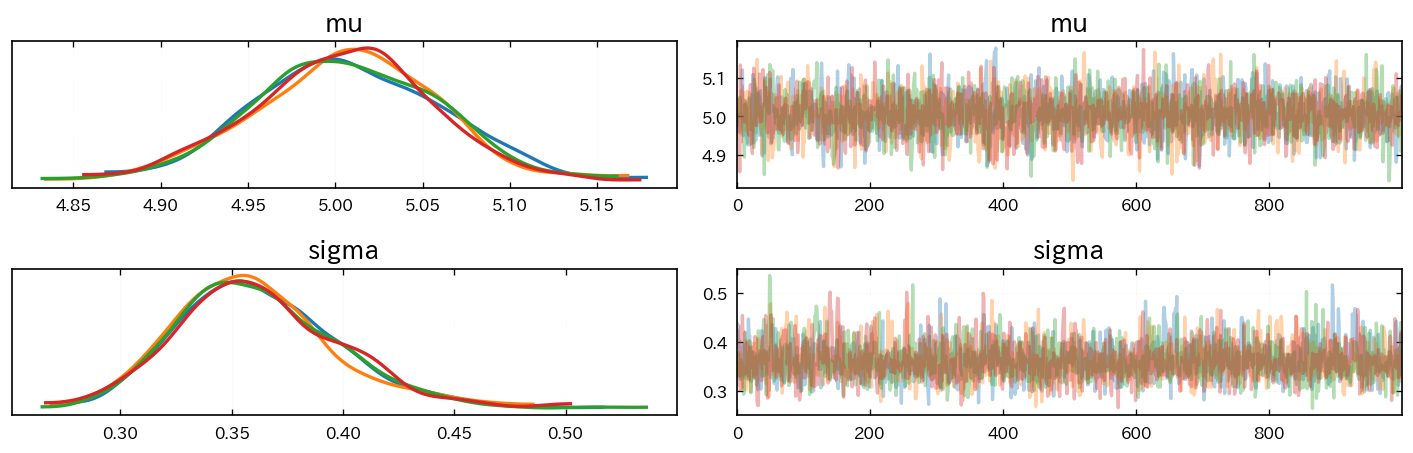

In [9]:
az.plot_trace(idata, compact = False)
plt.tight_layout()

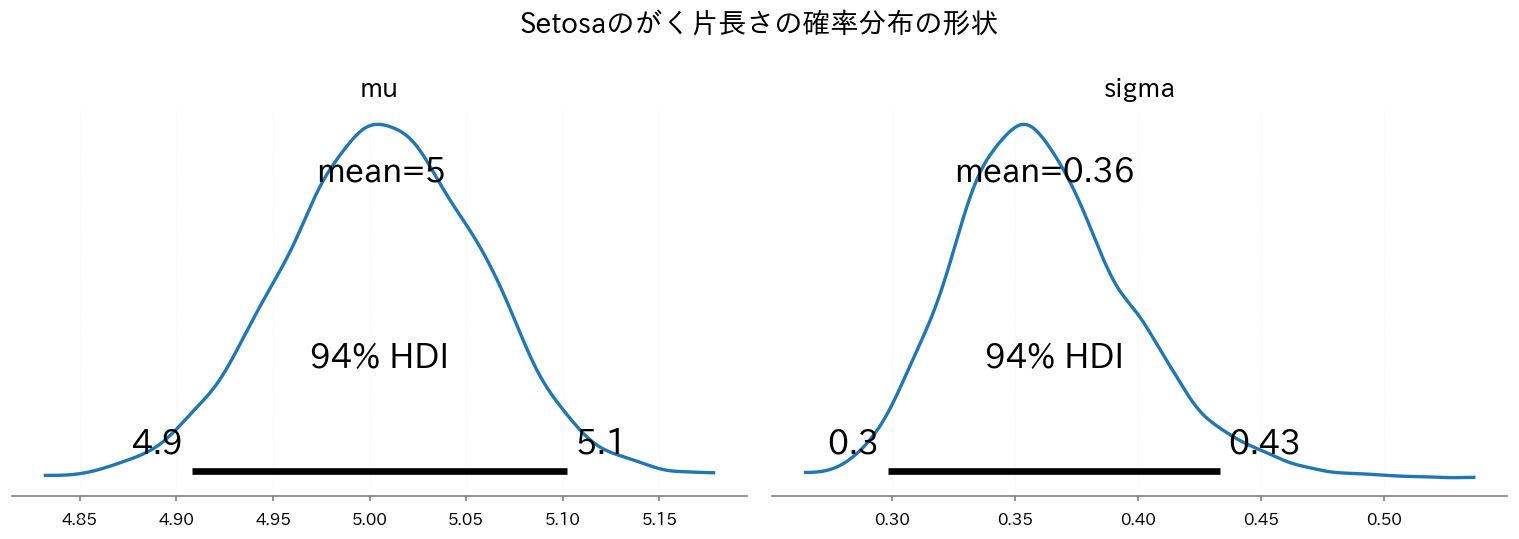

In [10]:
ax = az.plot_posterior(idata)
plt.suptitle("Setosaのがく片長さの確率分布の形状")
plt.tight_layout()
plt.show()

In [11]:
summary = az.summary(idata)
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.006,0.052,4.908,5.102,0.001,0.001,2675.0,2486.0,1.0
sigma,0.362,0.036,0.298,0.433,0.001,0.001,2564.0,2295.0,1.0


In [12]:
print(f"mu={summary.loc["mu", "mean"]}, sigma={summary.loc["sigma", "mean"]}")

mu=5.006, sigma=0.362


### 5.1.6 ヒストグラムと正規分布関数の重ね書き
ほぼ書籍のコードと同じ。

In [13]:
def norm(x, mu, sigma):
    """
    正規分布のラインプロットの確率密度関数の値を計算する
    """
    y = (x-mu)/sigma
    a = np.exp(-(y**2)/2)
    b = np.sqrt(2*np.pi)*sigma
    return a/b

In [14]:
x_min = Y.min()
x_max = Y.max()
x_list = np.arange(x_min, x_max, 0.01)
y_list = norm(x_list, summary.loc["mu", "mean"], summary.loc["sigma", "mean"])

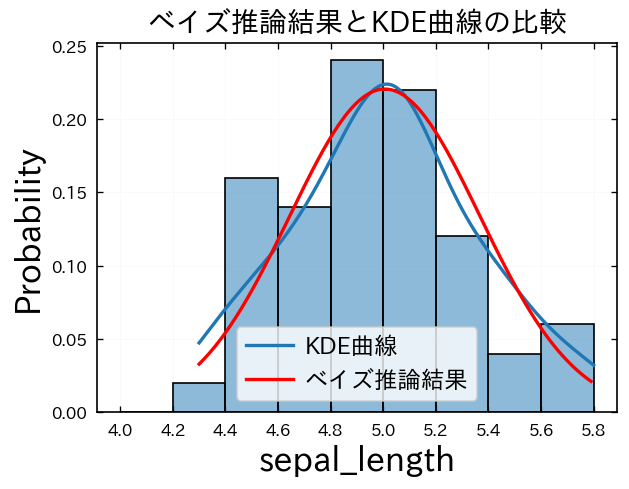

In [15]:
delta = 0.2
bins=np.arange(4.0, 6.0, delta)
fig, ax = plt.subplots()
sns.histplot(df_setosa, ax=ax, x='sepal_length',
    bins=bins, kde=True, stat='probability')
ax.get_lines()[0].set_label('KDE曲線')
ax.set_xticks(bins)
ax.plot(x_list, y_list*delta, c='r', label='ベイズ推論結果')
ax.set_title('ベイズ推論結果とKDE曲線の比較')
plt.legend();

### 5.1.7 少ないサンプル数でのベイズ推論
省略

### 